# 1、不同beta对训练的影响


In [7]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [24]:
# 从log中提取需要的内容
def extract_data_from_txt(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    rounds = []
    times = []
    train_losses = []
    ptest_accs = []
    g_accs = []
    
    round_pattern = re.compile(r'Train Round: (\d+)')
    time_pattern = re.compile(r'Time: ([\d-]+ [\d:]+)')
    train_loss_pattern = re.compile(r'train_loss: ([\d.]+)')
    ptest_acc_pattern = re.compile(r'ptest_acc:([\d.]+)')
    g_acc_pattern = re.compile(r"atest_acc:([\d.]+)")

    for line in lines:
        round_match = round_pattern.search(line)
        time_match = time_pattern.search(line)
        train_loss_match = train_loss_pattern.search(line)
        ptest_acc_match = ptest_acc_pattern.search(line)
        g_acc_match = g_acc_pattern.search(line)
        
        if round_match and time_match and train_loss_match and ptest_acc_match:
            rounds.append(int(round_match.group(1)))
            times.append(time_match.group(1))
            train_losses.append(float(train_loss_match.group(1)))
            ptest_accs.append(float(ptest_acc_match.group(1)))
            g_accs.append(float(g_acc_match.group(1)))
    return rounds, times, train_losses, ptest_accs,g_accs

In [25]:

def smooth_data(data, window_size=5):
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data

def plot_metrics(all_rounds, all_train_losses, all_ptest_accs, labels,save_name):
    plt.figure(figsize=(14, 7))
    
    for i in range(len(all_rounds)):
        rounds = all_rounds[i]
        train_losses = all_train_losses[i]
        ptest_accs = all_ptest_accs[i]
        
        smooth_train_losses = smooth_data(train_losses)
        smooth_ptest_accs = smooth_data(ptest_accs)
        smooth_rounds = rounds[:len(smooth_train_losses)]  # Adjust rounds to match smoothed data length
        
        # 绘制train_loss和round的变化
        plt.subplot(1, 2, 1)
        plt.plot(smooth_rounds, smooth_train_losses, marker='o', linestyle='-', label=labels[i])
        plt.xlabel('Round')
        plt.ylabel('Train Loss')
        
        # 绘制ptest_acc和round的变化
        plt.subplot(1, 2, 2)
        plt.plot(smooth_rounds, smooth_ptest_accs, marker='o', linestyle='-', label=labels[i])
        plt.xlabel('Round')
        plt.ylabel('PTest Accuracy')
    
    plt.subplot(1, 2, 1)
    plt.title('Train Loss vs. Round')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('PTest Accuracy vs. Round')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'result_analyze/{save_name}.png')
    plt.show()



def plot_two_metrics(rounds_data, acc_data, loss_data, labels, save_name):
    # 设置图形参数，适合学术出版
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.linewidth': 1.0,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'grid.alpha': 0.3,
        'figure.dpi': 300,
    })

    # 创建一个图形，包含两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 自定义颜色
    colors = ['#0072B2', '#D55E00', '#009E73']

    # 绘制 rounds vs accuracy
    for i in range(len(rounds_data)):
        rounds = rounds_data[i]
        acc = acc_data[i]
        ax1.plot(rounds, acc, label=labels[i], color=colors[i % len(colors)], linewidth=1.5)

    ax1.set_xlabel('Rounds', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Rounds vs Accuracy', fontsize=14, pad=10)
    ax1.legend(loc='best', frameon=False, fontsize=9)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.5)

    # 绘制 rounds vs loss
    for i in range(len(rounds_data)):
        rounds = rounds_data[i]
        loss = loss_data[i]
        ax2.plot(rounds, loss, label=labels[i], color=colors[i % len(colors)], linewidth=1.5)

    ax2.set_xlabel('Rounds', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Rounds vs Loss', fontsize=14, pad=10)
    ax2.legend(loc='best', frameon=False, fontsize=9)
    ax2.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.5)

    # 紧凑布局，避免元素重叠
    plt.tight_layout()

    # 保存图像为高分辨率PNG，背景透明
    plt.savefig(f'result_analyze/{save_name}.png', dpi=300, transparent=True)

    # 显示图形
    plt.show()

def compute_last_10_avg_and_std(all_ptest_accs, labels):
    for i in range(len(all_ptest_accs)):
        ptest_accs = all_ptest_accs[i]
        last_10_values = ptest_accs[-10:]
        avg_last_10 = np.mean(last_10_values)
        std_last_10 = np.std(last_10_values)
        print(f'{labels[i]}: Average of last 10 PTest Accuracies = {avg_last_10:.4f}, Std Dev = {std_last_10:.4f}')

def plot_rounds_vs_accuracy(rounds_data, acc_data, labels, save_name):
    # 设置图形参数，适合学术出版
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.linewidth': 1.0,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'grid.alpha': 0.3,
        'figure.dpi': 300,
    })

    # 创建一个图形
    fig, ax1 = plt.subplots(figsize=(6, 5))

    # 自定义颜色
    colors = ['#0072B2', '#D55E00', '#009E73']

    # 绘制 rounds vs accuracy
    for i in range(len(rounds_data)):
        rounds = rounds_data[i]
        acc = acc_data[i]
        ax1.plot(rounds, acc, label=labels[i], color=colors[i % len(colors)], linewidth=1.5)

    ax1.set_xlabel('Rounds', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Rounds vs Accuracy', fontsize=14, pad=10)
    ax1.legend(loc='best', frameon=False, fontsize=9)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.5)

    # 紧凑布局，避免元素重叠
    plt.tight_layout()

    # 保存图像为高分辨率PNG，背景透明
    plt.savefig(f'result_analyze/{save_name}.png', dpi=300, transparent=True)

    # 显示图形
    plt.show()


def read_and_plot_logs_list(file_paths,labels,save_name):
    all_rounds = []
    all_train_losses = []
    all_ptest_accs = []
    all_g_accs = []
    labels = labels
    
    for file_path in file_paths:
        rounds, times, train_losses, ptest_accs ,g_accs = extract_data_from_txt(file_path)
        all_rounds.append(rounds)
        all_train_losses.append(train_losses)
        all_ptest_accs.append(ptest_accs)
        all_g_accs.append(g_accs)
        # print(g_accs)
        # labels.append(os.path.basename(os.path.dirname(file_path)))  # 使用文件所在目录作为标签
    
    # plot_metrics(all_rounds, all_train_losses, all_ptest_accs, labels)
    # plot_rounds_vs_accuracy(all_rounds, all_g_accs, labels,save_name)
    plot_two_metrics(all_rounds, all_g_accs, all_train_losses, labels, save_name)
    # plot_metrics(all_rounds, all_train_losses, all_g_accs, labels)
    # plot_metrics(all_rounds, all_train_losses, all_g_accs, labels,save_name=save_name)

    compute_last_10_avg_and_std(all_g_accs, labels)

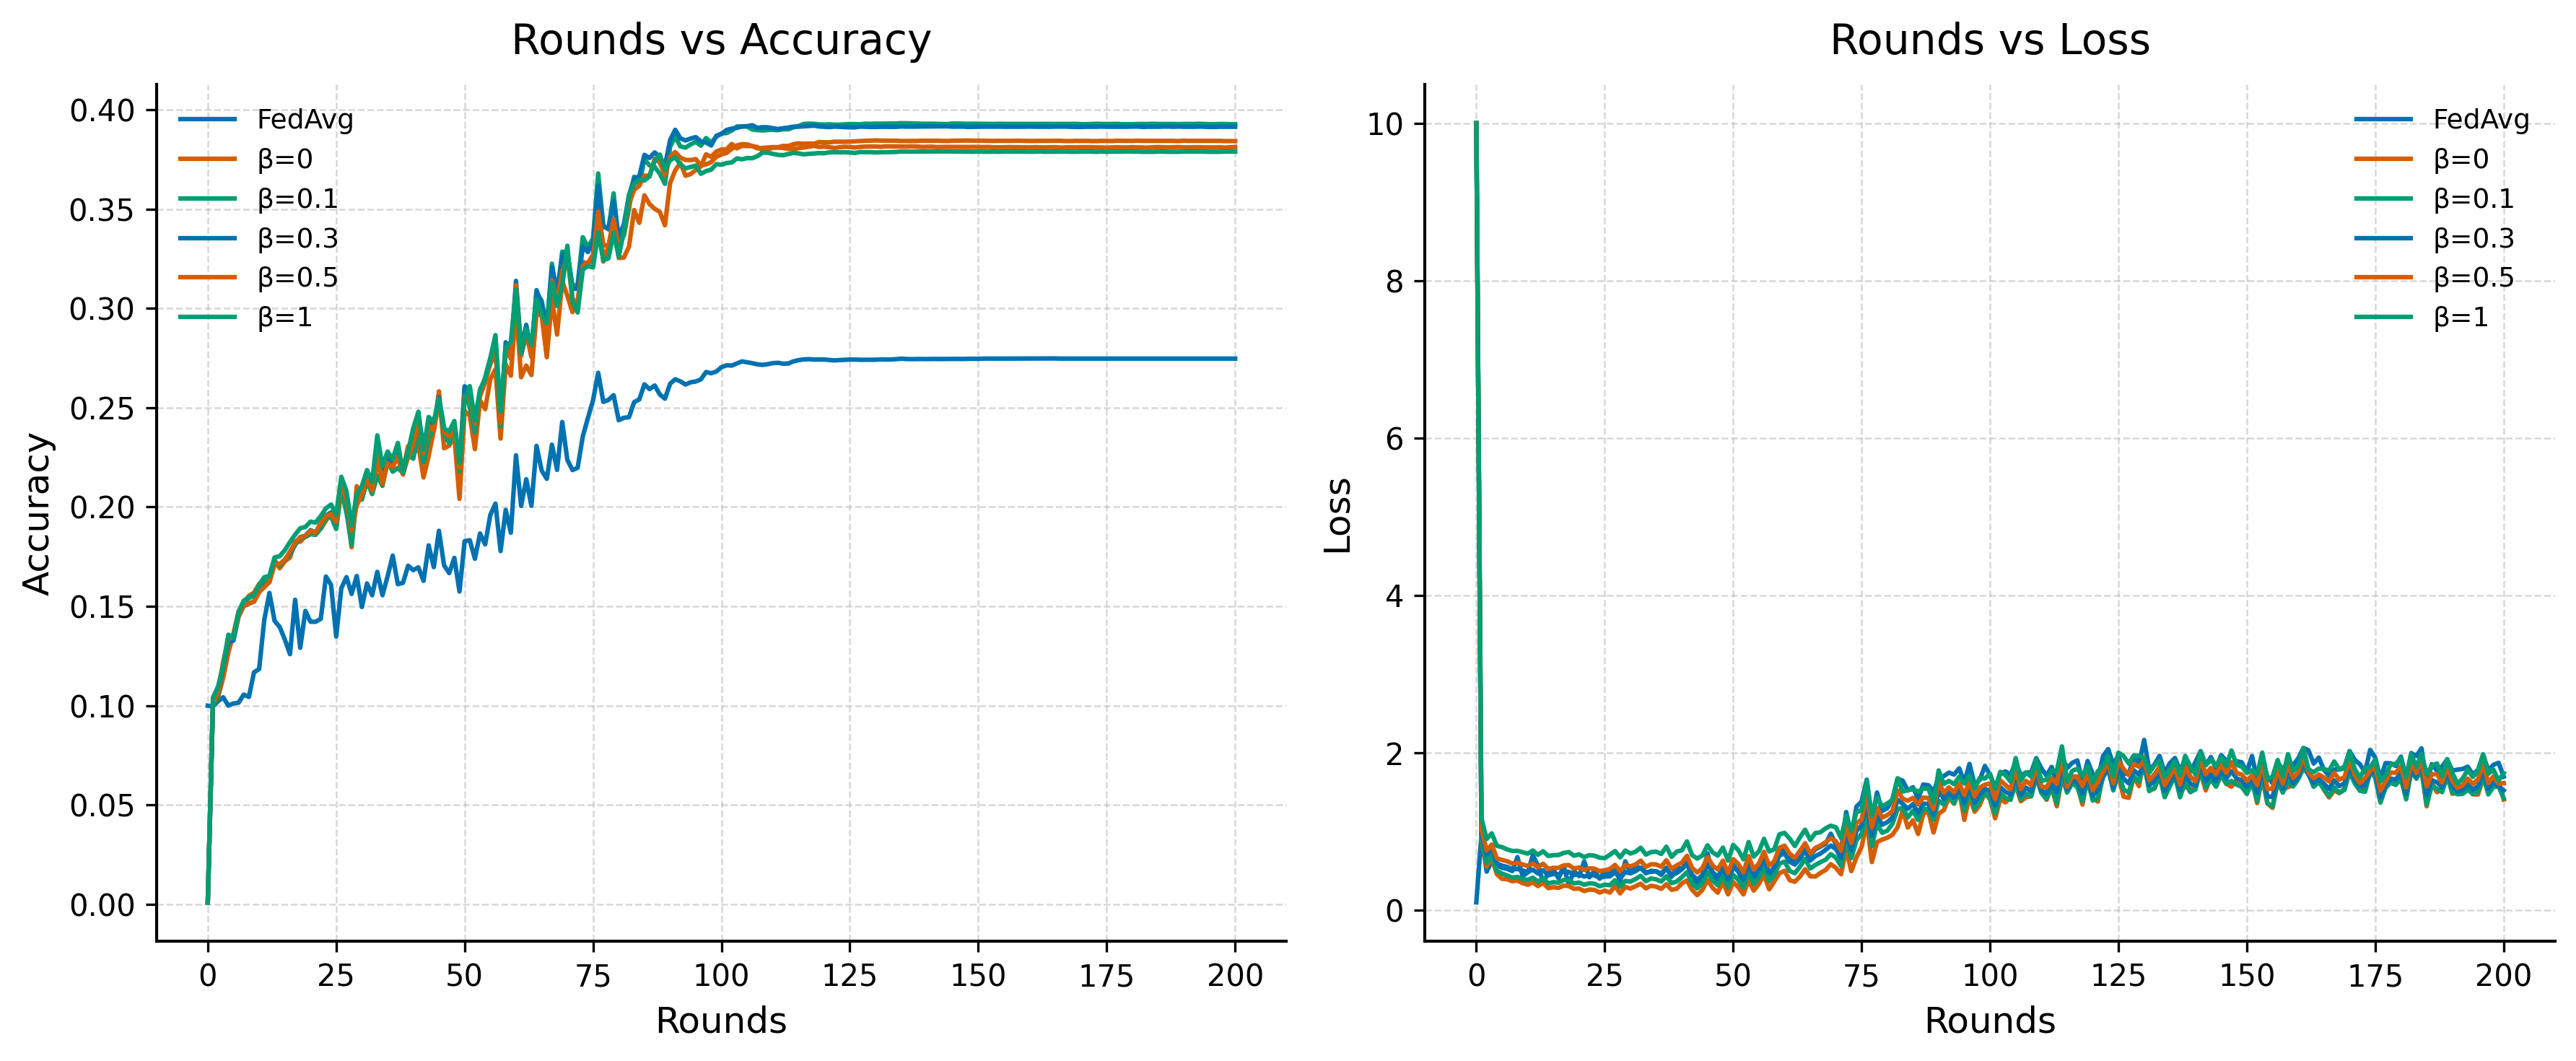

FedAvg: Average of last 10 PTest Accuracies = 0.2747, Std Dev = 0.0000
β=0: Average of last 10 PTest Accuracies = 0.3810, Std Dev = 0.0001
β=0.1: Average of last 10 PTest Accuracies = 0.3928, Std Dev = 0.0001
β=0.3: Average of last 10 PTest Accuracies = 0.3914, Std Dev = 0.0001
β=0.5: Average of last 10 PTest Accuracies = 0.3843, Std Dev = 0.0000
β=1: Average of last 10 PTest Accuracies = 0.3789, Std Dev = 0.0000


In [26]:
import matplotlib as mpl
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

file_paths = [
    './logs/fedAvg_logs/FL_16_cifar10_alex_0.1_200/fl_log.txt',
    './logs/fedclp_logs/FL_16_cifar10_alex_0.1_200/20240906_143742.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240910_093616.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_alpha0.1_200_beta0.3/20240909_174350.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_0.1_200_beta0.5/20240908_183505.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_0.1_200/20240907_081138.txt']

labels = ["FedAvg",'β=0','β=0.1','β=0.3','β=0.5','β=1'] 
save_name = "beta_impact_accuracy_loss"
read_and_plot_logs_list(file_paths,labels,save_name)

# 修改为 center loss 和 accuracy

In [47]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# 从log中提取需要的内容
def extract_center_loss_acc(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    rounds = []
    times = []
    center_losses = []
    center_accs = []
    
    pattern = r"center_loss:([\d\.]+),center_acc:([\d\.]+)"
    round_pattern = re.compile(r'Train Round: (\d+)')
    time_pattern = re.compile(r'Time: ([\d-]+ [\d:]+)')

    for line in lines:
        round_match = round_pattern.search(line)
        time_match = time_pattern.search(line)
        acc_loss_match = re.search(pattern, line)
        
        if round_match and time_match and acc_loss_match:
            rounds.append(int(round_match.group(1)))
            times.append(time_match.group(1))
            center_loss = float(acc_loss_match.group(1))
            center_acc = float(acc_loss_match.group(2))
            center_accs.append(center_acc)
            center_losses.append(center_loss)

    return rounds, times, center_losses,center_accs


def smooth_data(data, window_size=5):
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data

def plot_metrics(all_rounds, all_train_losses, all_ptest_accs, labels,save_name):
    plt.figure(figsize=(14, 7))
    
    for i in range(len(all_rounds)):
        rounds = all_rounds[i]
        train_losses = all_train_losses[i]
        ptest_accs = all_ptest_accs[i]
        
        smooth_train_losses = smooth_data(train_losses)
        smooth_ptest_accs = smooth_data(ptest_accs)
        smooth_rounds = rounds[:len(smooth_train_losses)]  # Adjust rounds to match smoothed data length
        
        # 绘制train_loss和round的变化
        plt.subplot(1, 2, 1)
        plt.plot(smooth_rounds, smooth_train_losses, marker='o', linestyle='-', label=labels[i])
        plt.xlabel('Round')
        plt.ylabel('Train Loss')
        
        # 绘制ptest_acc和round的变化
        plt.subplot(1, 2, 2)
        plt.plot(smooth_rounds, smooth_ptest_accs, marker='o', linestyle='-', label=labels[i])
        plt.xlabel('Round')
        plt.ylabel('PTest Accuracy')
    
    plt.subplot(1, 2, 1)
    plt.title('Train Loss vs. Round')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('PTest Accuracy vs. Round')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'result_analyze/{save_name}.png')
    plt.show()




def plot_two_metrics(rounds_data, acc_data, loss_data, labels, save_name):
    # 设置Seaborn风格，适合学术出版
    sns.set(style="whitegrid", font='Arial', font_scale=1.2)
    
    # 创建一个图形，包含两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 自定义颜色列表
    # colors = ['#0072B2', '#D55E00', '#009E73', '#FB8072', '#FFD573', '#C44E52']
    colors = ['#1f77b4',  # 蓝色
        '#ff7f0e',  # 橙色
        '#2ca02c',  # 绿色
        '#d62728',  # 红色
        '#9467bd',  # 紫色
        '#8c564b'   # 棕色
              ]

    # 绘制 rounds vs accuracy
    for i in range(len(acc_data)):
        rounds = rounds_data[i]
        acc = acc_data[i]
        ax1.plot(rounds, acc, label=labels[i], color=colors[i], linewidth=1.5)

    ax1.set_xlabel('Rounds', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Rounds vs Accuracy', fontsize=14, pad=10)
    ax1.legend(loc='best', frameon=False, fontsize=9)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.5)

    # 绘制 rounds vs loss
    for i in range(len(loss_data)):
        rounds = rounds_data[i]
        loss = loss_data[i]
        ax2.plot(rounds, loss, label=labels[i], color=colors[i], linewidth=1.5)

    ax2.set_xlabel('Rounds', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Rounds vs Loss', fontsize=14, pad=10)
    ax2.legend(loc='best', frameon=False, fontsize=9)
    ax2.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.5)

    # 紧凑布局，避免元素重叠
    plt.tight_layout()

    # 保存图像为高分辨率PNG，背景透明
    plt.savefig(f'result_analyze/{save_name}.png', dpi=300, transparent=True)

    # 显示图形
    plt.show()

def compute_last_10_avg_and_std(all_ptest_accs, labels):
    for i in range(len(all_ptest_accs)):
        ptest_accs = all_ptest_accs[i]
        last_10_values = ptest_accs[-10:]
        avg_last_10 = np.mean(last_10_values)
        std_last_10 = np.std(last_10_values)
        print(f'{labels[i]}: Average of last 10 PTest Accuracies = {avg_last_10:.4f}, Std Dev = {std_last_10:.4f}')

def read_and_plot_logs_list(file_paths,labels,save_name):
    all_rounds = []
    all_train_losses = []
    all_g_accs = []
    labels = labels
    
    for file_path in file_paths:
        rounds, times, train_losses,g_accs = extract_center_loss_acc(file_path)
        all_rounds.append(rounds)
        all_train_losses.append(train_losses)
        all_g_accs.append(g_accs)
        # print(g_accs)
        # labels.append(os.path.basename(os.path.dirname(file_path)))  # 使用文件所在目录作为标签
    
    # plot_metrics(all_rounds, all_train_losses, all_ptest_accs, labels)
    # plot_rounds_vs_accuracy(all_rounds, all_g_accs, labels,save_name)
    plot_two_metrics(all_rounds, all_g_accs, all_train_losses, labels, save_name)
    # plot_metrics(all_rounds, all_train_losses, all_g_accs, labels)
    # plot_metrics(all_rounds, all_train_losses, all_g_accs, labels,save_name=save_name)

    compute_last_10_avg_and_std(all_g_accs, labels)

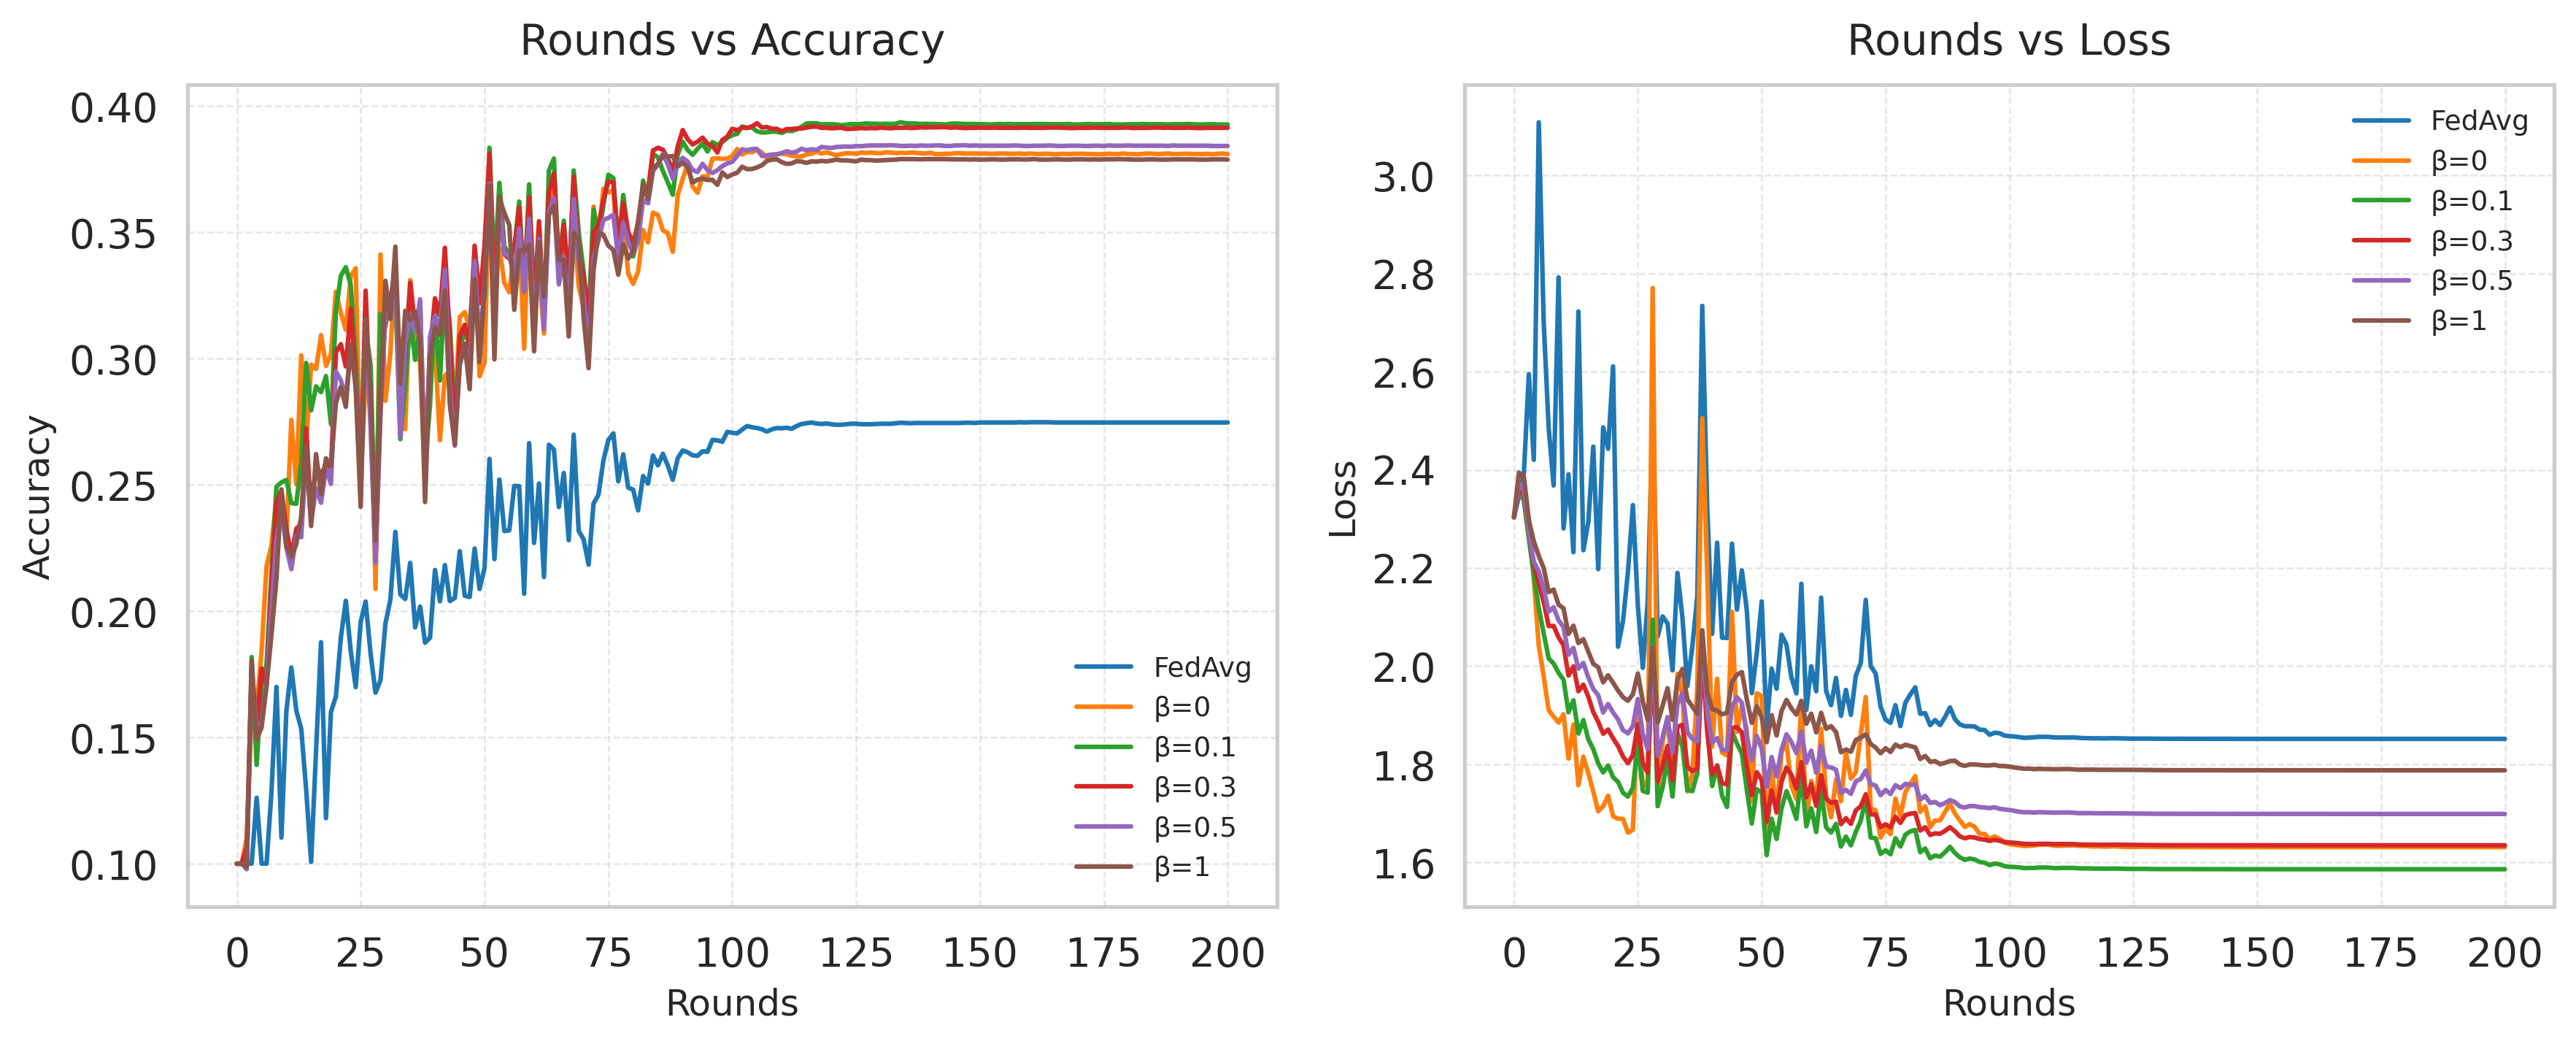

FedAvg: Average of last 10 PTest Accuracies = 0.2747, Std Dev = 0.0000
β=0: Average of last 10 PTest Accuracies = 0.3810, Std Dev = 0.0001
β=0.1: Average of last 10 PTest Accuracies = 0.3928, Std Dev = 0.0001
β=0.3: Average of last 10 PTest Accuracies = 0.3914, Std Dev = 0.0001
β=0.5: Average of last 10 PTest Accuracies = 0.3843, Std Dev = 0.0000
β=1: Average of last 10 PTest Accuracies = 0.3789, Std Dev = 0.0000


In [48]:
import matplotlib as mpl
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

file_paths = [
    './logs/fedAvg_logs/FL_16_cifar10_alex_0.1_200/fl_log.txt',
    './logs/fedclp_logs/FL_16_cifar10_alex_0.1_200/20240906_143742.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240910_093616.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_alpha0.1_200_beta0.3/20240909_174350.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_0.1_200_beta0.5/20240908_183505.txt',
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_0.1_200/20240907_081138.txt']

labels = ["FedAvg",'β=0','β=0.1','β=0.3','β=0.5','β=1'] 
save_name = "beta_impact_accuracy_loss"
read_and_plot_logs_list(file_paths,labels,save_name)